In [46]:
import numpy as np
import pandas as pd
import re

from collections import Counter
import string

import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding, Dropout
from keras.layers import Input
from keras.optimizers import Adam
from keras.models import load_model
from keras.losses import CategoricalCrossentropy
from keras.losses import SparseCategoricalCrossentropy
from keras import Model

from tf2crf import CRF
from tf2crf import CRF, ModelWithCRFLoss


#from keras_contrib.layers import CRF
# from sklearn_crfsuite import CRF
#from keras_contrib.losses import crf_loss
#from keras_contrib.metrics import crf_viterbi_accuracy

from konlpy.tag import Kkma
from konlpy.tag import Mecab
from konlpy.utils import pprint
from konlpy.tag import Twitter,Okt

from transformers import BertModel
# from tokenization_kobert import KoBertTokenizer

import os

from tqdm import tqdm

import matplotlib.pyplot as plt
import plotly.express as px


from keras.callbacks import Callback
from keras.utils.vis_utils import plot_model
from seqeval.metrics import f1_score, classification_report

In [19]:
import tensorflow as tf
print(tf.__version__)

2.4.0


In [21]:
path_ = r"C:\Users\Samsung\jupyter\Project_Deep_learning_2020\data\NER"
file_list = os.listdir(path_)
file_list_xlsx = [f for f in file_list if f.endswith(".csv")]
file_list_xlsx

['airpro.csv', 'buds.csv']

In [22]:
file_list_xlsx

['airpro.csv', 'buds.csv']

In [23]:
airpro = pd.read_csv(r"C:\Users\Samsung\jupyter\Project_Deep_learning_2020\data\NER\airpro.csv",index_col = 0)
buds = pd.read_csv(r"C:\Users\Samsung\jupyter\Project_Deep_learning_2020\data\NER\buds.csv",index_col = 0)

In [24]:
buds.head()

,word,rule_label,IOB,sentence,enter,review,pos
0,☆☆,O,NaN,0,0,0,Foreign
1,나름,O,NaN,0,0,0,Noun
2,음향,SQ,B,0,0,0,Noun
3,기기,O,NaN,0,0,0,Noun
4,좋아하다,O,NaN,0,0,0,Adjective


In [25]:
def NER_generator(df):
    df["IOB"] = df["IOB"].fillna("O")
    df["rule_label"] = df.rule_label.replace("O","")
    df["NER"] = df["IOB"] + "-" + df["rule_label"]
    df["NER"] = df.NER.replace("O-","O")
    return df

In [26]:
airpro = NER_generator(airpro)
buds = NER_generator(buds)

In [27]:
buds.head()

,word,rule_label,IOB,sentence,enter,review,pos,NER
0,☆☆,,O,0,0,0,Foreign,O
1,나름,,O,0,0,0,Noun,O
2,음향,SQ,B,0,0,0,Noun,B-SQ
3,기기,,O,0,0,0,Noun,O
4,좋아하다,,O,0,0,0,Adjective,O


In [28]:
df_ = buds.copy()
def IOB_insert(df_):
    for i in range(10):
        index_ = []
        for i in range(len(df_)):
            a = df_.loc[i,"IOB"]
            if a == "I":
                b = df_.loc[i-1,"IOB"]
                if b == "O":
                    index_.append(i-1)
                    #print(i-1)
        if len(index_) ==0:
            break
        for i in index_:
            df_.loc[i,"IOB"] = "I"
        print("---------------------------")
    return df_

In [29]:
buds_in = IOB_insert(buds)
airpro_in = IOB_insert(airpro)

---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------


airpro 에 전처리 문제 있음

In [30]:
data_ = buds_in

elw = data_.groupby('enter').count()
iqr = elw['word'].describe()
iqr

count    777.000000
mean      23.823681
std       31.254502
min        1.000000
25%        7.000000
50%       14.000000
75%       26.000000
max      362.000000
Name: word, dtype: float64

In [31]:
iqr_v = iqr['75%'] - iqr['25%']
iqr['75%'] + 1.5* iqr_v

54.5

{'whiskers': [<matplotlib.lines.Line2D at 0x215c50949c8>,
 'caps': [<matplotlib.lines.Line2D at 0x215c4fd0208>,
 'boxes': [<matplotlib.lines.Line2D at 0x215cc6e4c08>],
 'medians': [<matplotlib.lines.Line2D at 0x215cc6e3f88>],
 'fliers': [<matplotlib.lines.Line2D at 0x215cc6e3fc8>],
 'means': []}

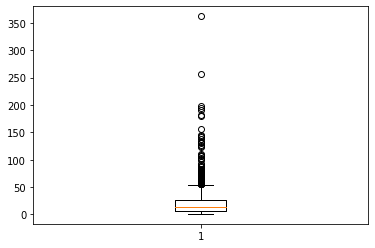

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.boxplot(elw['word'])

In [33]:

fig = px.box(elw, y="word")
fig.update_layout(

    paper_bgcolor='rgb(500,500,500)',
    plot_bgcolor='rgb(250,250,250)',
)
fig.show()

리뷰의 최대 길이 : 362


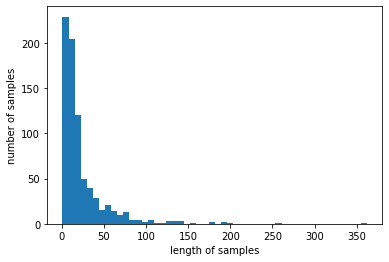

In [34]:
elw = data_.groupby('enter').count()
slw = data_.groupby('sentence').count()
length = data_['enter'].unique()
func = lambda temp: [(w, t) for w, t in zip(temp["word"].values.tolist(), temp["NER"].values.tolist())]
tagged_sentences=[t for t in data_.groupby("enter").apply(func)]
sentences, ner_tags = [], [] 
for tagged_sentence in tagged_sentences: # 47,959개의 문장 샘플을 1개씩 불러온다.
    sentence, tag_info = zip(*tagged_sentence) # 각 샘플에서 단어들은 sentence에 개체명 태깅 정보들은 tag_info에 저장.
    sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장한다.
    ner_tags.append(list(tag_info)) # 각 샘플에서 개체명 태깅 정보만 저장한다.
print('리뷰의 최대 길이 : %d' % max(len(l) for l in tagged_sentences))
plt.hist([len(s) for s in tagged_sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [35]:
a = pd.DataFrame([len(s) for s in tagged_sentences])
fig = px.histogram(a, x=0, marginal="rug")
fig.update_layout(

    paper_bgcolor='rgb(500,500,500)',
    plot_bgcolor='rgb(250,250,250)',
)
fig.show()

In [36]:
src_tokenizer = Tokenizer(oov_token='OOV') # 모든 단어를 사용하지만 인덱스 1에는 단어 'OOV'를 할당한다.
src_tokenizer.fit_on_texts(sentences)
tar_tokenizer = Tokenizer(lower=False) # 태깅 정보들은 내부적으로 대문자를 유지한채로 저장
tar_tokenizer.fit_on_texts(ner_tags)

In [37]:
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 2727
개체명 태깅 정보 집합의 크기 : 33


In [38]:
X = src_tokenizer.texts_to_sequences(sentences)
y= tar_tokenizer.texts_to_sequences(ner_tags)
word_to_index = src_tokenizer.word_index
index_to_word = src_tokenizer.index_word
ner_to_index = tar_tokenizer.word_index
index_to_ner = tar_tokenizer.index_word
index_to_ner[0] = 'PAD'

In [39]:
decoded = []
for index in X[5] : # 첫번째 샘플 안의 인덱스들에 대해서
    decoded.append(index_to_word[index]) # 다시 단어로 변환

print('기존 문장 : {}'.format(sentences[5]))
print('디코딩 문장 : {}'.format(decoded))

기존 문장 : ['《', '인트', '로', '》']
디코딩 문장 : ['《', '인트', '로', '》']


In [40]:
max_len = 70
# 모든 샘플들의 길이를 맞출 때 뒤의 공간에 숫자 0으로 채움.
X = pad_sequences(X, padding='post', maxlen=max_len)
y = pad_sequences(y, padding='post', maxlen=max_len)

In [105]:
y[0]

array([1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=777)
y_train[0]

array([16, 22,  1,  1,  1,  1,  1,  2,  4,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0])

In [107]:
#y_train = to_categorical(y_train, num_classes=tag_size)
#y_test = to_categorical(y_test, num_classes=tag_size)

In [108]:
y_train[0]

array([16, 22,  1,  1,  1,  1,  1,  2,  4,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0])

In [109]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (621, 70)
훈련 샘플 레이블의 크기 : (621, 70)
테스트 샘플 문장의 크기 : (156, 70)
테스트 샘플 레이블의 크기 : (156, 70)


In [41]:
class F1score(Callback):
    def __init__(self, value = 0.0, use_char=True ):
        super(F1score, self).__init__()
        self.value = value
        self.use_char = use_char

    def sequences_to_tags(self, sequences): # 예측값을 index_to_ner를 사용하여 태깅 정보로 변경하는 함수.
        result = []
        for sequence in sequences: # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
            tag = []
            for pred in sequence: # 시퀀스로부터 예측값을 하나씩 꺼낸다.
                pred_index = np.argmax(pred) # 예를 들어 [0, 0, 1, 0 ,0]라면 1의 인덱스인 2를 리턴한다.
                tag.append(index_to_ner[pred_index].replace("PAD", "O")) # 'PAD'는 'O'로 변경
            result.append(tag)
        return result

    # 에포크가 끝날 때마다 실행되는 함수
    def on_epoch_end(self, epoch, logs={}):
        print(self.validation_data)

In [96]:
# address some inteeface discrepancies when using tensorflow.keras
if "slice" not in K.__dict__ and K.backend() == "tensorflow":
    # this is a good indicator that we are using tensorflow.keras

    try:
        # at first try to monkey patch what we need, will only work if keras-team keras is installed
        from keras import backend as KKK

        try:
            K.__dict__.update(
                is_tensor=KKK.is_tensor,
                slice=KKK.slice,
            )
        finally:
            del KKK
    except ImportError:
        # if that doesn't work we do a dirty copy of the code required
        import tensorflow as tf
        from tensorflow.python.framework import ops as tf_ops


        def is_tensor(x):
            return isinstance(x, tf_ops._TensorLike) or tf_ops.is_dense_tensor_like(x)


        def slice(x, start, size):
            x_shape = K.int_shape(x)
            if (x_shape is not None) and (x_shape[0] is not None):
                len_start = K.int_shape(start)[0] if is_tensor(start) else len(start)
                len_size = K.int_shape(size)[0] if is_tensor(size) else len(size)
                if not (len(K.int_shape(x)) == len_start == len_size):
                    raise ValueError('The dimension and the size of indices should match.')
            return tf.slice(x, start, size)

AttributeError: 'CRF' object has no attribute 'backend'

In [26]:
tag_size

33

In [111]:
model = Sequential()
model.add(Embedding(vocab_size, 128, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
crf = CRF(tag_size)
model.add(crf)
#model.add(TimeDistributed(Dense(tag_size, activation=('softmax'))))

ValueError: Could not interpret initializer identifier: 33

In [112]:
inputs = Input(shape=(70,), dtype='int32')
output = Embedding(vocab_size, 128, input_length=max_len, mask_zero=True)(inputs)
output = Bidirectional(LSTM(256, return_sequences=True))(output)
output = Dense(tag_size, activation=None)(output)
crf = CRF(dtype='float32')
output = crf(output)
base_model = Model(inputs, output)

In [113]:
tag_size

33

In [114]:
model = ModelWithCRFLoss(base_model)
model.compile(optimizer='adam', metrics=['accuracy'])

In [115]:
X_train.shape

(621, 70)

In [116]:
history = model.fit(X_train, y_train, batch_size=128, epochs=50,  validation_split=0.1)#, callbacks=[F1score(use_char=False)])

Epoch 1/50
5/5 [==============================] - 12s 1s/step - crf_loss: 69.4796 - accuracy: 0.0146 - val_crf_loss_val: 57.0952 - val_val_accuracy: 0.5911
Epoch 2/50
5/5 [==============================] - 3s 564ms/step - crf_loss: 41.4443 - accuracy: 0.7834 - val_crf_loss_val: 30.6434 - val_val_accuracy: 0.8642
Epoch 3/50
5/5 [==============================] - 3s 618ms/step - crf_loss: 27.8554 - accuracy: 0.8690 - val_crf_loss_val: 21.5927 - val_val_accuracy: 0.8709
Epoch 4/50
5/5 [==============================] - 3s 649ms/step - crf_loss: 20.2522 - accuracy: 0.8722 - val_crf_loss_val: 18.8317 - val_val_accuracy: 0.8725
Epoch 5/50
5/5 [==============================] - 4s 698ms/step - crf_loss: 19.0191 - accuracy: 0.8725 - val_crf_loss_val: 16.8578 - val_val_accuracy: 0.8742
Epoch 6/50
5/5 [==============================] - 4s 685ms/step - crf_loss: 16.7884 - accuracy: 0.8725 - val_crf_loss_val: 15.9044 - val_val_accuracy: 0.8742
Epoch 7/50
5/5 [==============================] - 4s 7

In [124]:
loss_,accu_= model.evaluate(X_test,y_test)
y_pred = model.predict(X_test)
accu_

5/5 [==============================] - 1s 107ms/step - crf_loss_val: 6.1522 - val_accuracy: 0.9434


0.9388632774353027

In [133]:
hist = pd.DataFrame(history.history)
hist.tail()

,crf_loss,accuracy,val_crf_loss_val,val_val_accuracy
45,3.373599,0.956836,5.151947,0.957781
46,2.877688,0.959385,5.032083,0.959437
47,2.807037,0.959045,4.940145,0.957781
48,2.818157,0.960829,4.935975,0.959437
49,3.044605,0.962954,4.880503,0.960265


In [42]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(12,12))
    #plt.plot()
    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_val_accuracy'],
           label = 'Val Error')
    plt.ylim([0.6,1])
    plt.title("Accuracy")
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.plot(hist['epoch'], hist['crf_loss'],
           label='Train loss')
    plt.plot(hist['epoch'], hist['val_crf_loss_val'],
           label = 'Val loss')
    #plt.ylim([0.6,1])
    plt.title("Loss")
    plt.legend()
    
    plt.show()
    return hist

In [43]:
def plot_history2(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(12,12))
    #plt.plot()
    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_accuracy'],
           label = 'Val Error')
    plt.ylim([0.6,1])
    plt.title("Accuracy")
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.plot(hist['epoch'], hist['loss'],
           label='Train loss')
    plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val loss')
    #plt.ylim([0.6,1])
    plt.title("Loss")
    plt.legend()
    
    plt.show()
    return hist

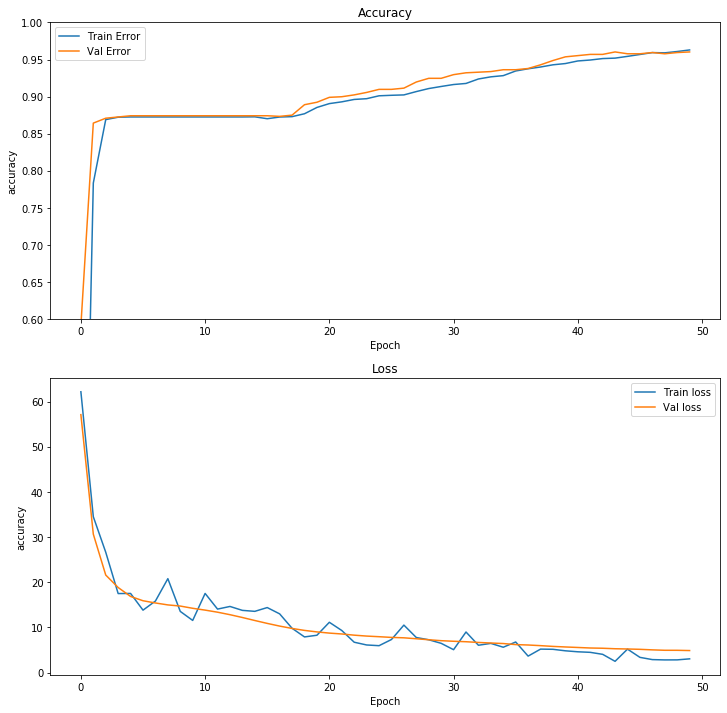

In [150]:
plot_history(history)

In [118]:
f1score = F1score()

y_predicted = model.predict([X_test])
#pred_tags = f1score.sequences_to_tags(y_predicted)
#test_tags = f1score.sequences_to_tags(y_test)

In [119]:
y_predicted

(array([[ 1,  1,  1, ...,  1,  1,  1],
        [ 1,  1,  1, ...,  3,  3,  3],
        [ 7, 11,  8, ...,  1,  1,  1],
        ...,
        [ 5,  5,  1, ...,  1,  1,  1],
        [ 1,  1,  1, ...,  1,  1,  1],
        [ 1,  1,  1, ...,  1,  1,  1]]),
 array([[[-3.6094949e+00,  4.7154903e+00, -3.6126128e-01, ...,
          -3.1398063e+00, -2.5321140e+00, -3.7944992e+00],
         [-2.4378443e+00,  3.3307712e+00, -3.9904572e-02, ...,
          -2.1741998e+00, -1.5813786e+00, -2.5160348e+00],
         [-2.9197149e+00,  5.6253953e+00, -2.9124984e-01, ...,
          -2.8429580e+00, -1.6856391e+00, -3.0235183e+00],
         ...,
         [-2.4094863e-02,  2.5523528e-02, -2.3217421e-02, ...,
          -2.6586369e-02, -2.3484878e-02, -2.4770450e-02],
         [-2.4094863e-02,  2.5523528e-02, -2.3217421e-02, ...,
          -2.6586369e-02, -2.3484878e-02, -2.4770450e-02],
         [-2.4094863e-02,  2.5523528e-02, -2.3217421e-02, ...,
          -2.6586369e-02, -2.3484878e-02, -2.4770450e-02]],
 
  

In [157]:
i=54 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
#y_predicted = np.argmax(y_predicted, axis=-1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.
true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(X_test[i], true, y_predicted[0]):
    if w != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[w], index_to_ner[t], index_to_ner[pred]))

단어             |실제값  |예측값
-----------------------------------


TypeError: zip argument #2 must support iteration

In [153]:
y_predicted = model.predict(np.array([X_test[i]]))

In [158]:
true

2

In [160]:
y_test[i]

array([1, 5, 8, 8, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

In [159]:
y_predicted[0]

array([[1, 5, 1, 1, 1, 1, 1, 5, 1, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1]])

# LSTM

In [131]:
X = pad_sequences(X, padding='post', maxlen=max_len)
y = pad_sequences(y, padding='post', maxlen=max_len)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=777)
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

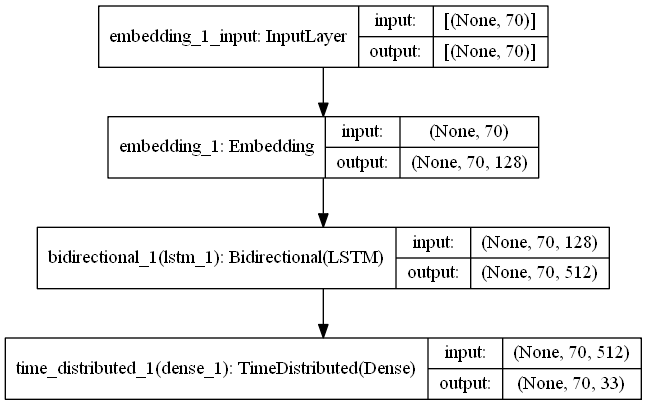

In [48]:
model2 = Sequential()
model2.add(Embedding(vocab_size, 128, input_length=max_len, mask_zero=True))
model2.add(Bidirectional(LSTM(256, return_sequences=True)))
model2.add(TimeDistributed(Dense(tag_size, activation=('softmax'))))
model2.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
plot_model(model2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [203]:




history2 = model2.fit(X_train, y_train, batch_size=128, epochs=50,  validation_split=0.1)#, callbacks=[F1score(use_char=False)])


Epoch 1/50
5/5 [==============================] - 12s 2s/step - loss: 1.0486 - accuracy: 0.5064 - val_loss: 0.8499 - val_accuracy: 0.8750
Epoch 2/50
5/5 [==============================] - 6s 1s/step - loss: 0.7547 - accuracy: 0.8724 - val_loss: 0.4309 - val_accuracy: 0.8750
Epoch 3/50
5/5 [==============================] - 6s 1s/step - loss: 0.4056 - accuracy: 0.8721 - val_loss: 0.3150 - val_accuracy: 0.8750
Epoch 4/50
5/5 [==============================] - 6s 1s/step - loss: 0.3207 - accuracy: 0.8753 - val_loss: 0.2615 - val_accuracy: 0.8750
Epoch 5/50
5/5 [==============================] - 6s 1s/step - loss: 0.2696 - accuracy: 0.8750 - val_loss: 0.2529 - val_accuracy: 0.8750
Epoch 6/50
5/5 [==============================] - 7s 1s/step - loss: 0.2751 - accuracy: 0.8727 - val_loss: 0.2315 - val_accuracy: 0.8750
Epoch 7/50
5/5 [==============================] - 7s 1s/step - loss: 0.2582 - accuracy: 0.8709 - val_loss: 0.2270 - val_accuracy: 0.8750
Epoch 8/50
5/5 [========================

In [205]:
tf.keras.models.save_model(model2, r'C:\Users\Samsung\jupyter\Project_Deep_learning_2020\data\NER\model\LSTM')

INFO:tensorflow:Assets written to: C:\Users\Samsung\jupyter\Project_Deep_learning_2020\data\NER\model\LSTM\assets


INFO:tensorflow:Assets written to: C:\Users\Samsung\jupyter\Project_Deep_learning_2020\data\NER\model\LSTM\assets


In [206]:
loss_,accu_= model2.evaluate(X_test,y_test)
y_pred = model2.predict(X_test)
accu_

5/5 [==============================] - 1s 145ms/step - loss: 0.0982 - accuracy: 0.9272


0.9271889328956604

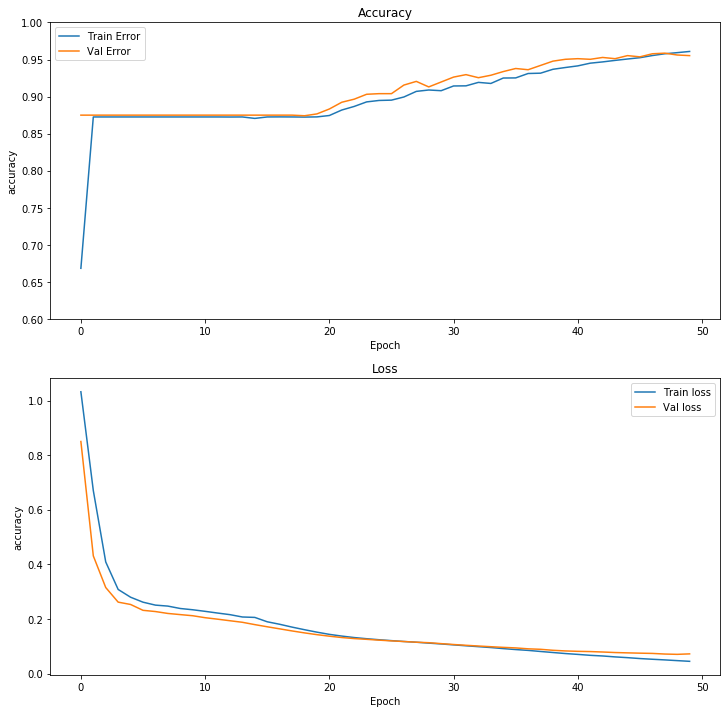

In [211]:
hist2 = plot_history2(history2)

In [212]:
hist2.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
45,0.054804,0.952502,0.074533,0.953642,45
46,0.052223,0.955391,0.073617,0.957781,46
47,0.049852,0.957770,0.071322,0.958609,47
48,0.047219,0.959300,0.070208,0.956126,48
49,0.044651,0.960914,0.071925,0.955298,49


In [219]:
for i in [54,20,100,22,25,150,40]:
    y_predicted = model2.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
    y_predicted = np.argmax(y_predicted, axis=-1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.
    true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.
    print("target: ",i)
    print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
    print(35 * "-")

    for w, t, pred in zip(X_test[i], true, y_predicted[0]):
        if w != 0: # PAD값은 제외함.
            print("{:17}: {:7} {}".format(index_to_word[w], index_to_ner[t], index_to_ner[pred]))
    print("==================================")

target:  54
단어             |실제값  |예측값
-----------------------------------
(                : O       O
노이즈              : B-NC    B-NC
켄                : I-NC    O
슬링               : I-NC    I-NC
)                : O       O
생각               : O       O
보다               : O       O
차단               : B-NC    B-DE
이                : O       O
100              : O       O
프로               : O       I-SQ
안되다              : O       O
.                : O       O
바깥               : O       O
소리               : O       O
가                : O       O
웅웅               : O       O
울리다              : O       O
들리다              : O       O
.                : O       O
target:  20
단어             |실제값  |예측값
-----------------------------------
안좋다              : O       O
target:  100
단어             |실제값  |예측값
-----------------------------------
뚜껑               : B-CA    B-COM
만                : O       O
열                : O       O
어도               : O       O
연결               : B-PAR   B-COM
잘  

In [132]:
f1score = F1score()

y_predicted = model2.predict([X_test])
pred_tags = f1score.sequences_to_tags(y_predicted)
test_tags = f1score.sequences_to_tags(y_test)

In [133]:
y_predicted

array([[[0.03046859, 0.03032652, 0.02999104, ..., 0.03016053,
         0.03024398, 0.03019759],
        [0.03012526, 0.0302436 , 0.03006522, ..., 0.03029002,
         0.03017601, 0.03022243],
        [0.0300211 , 0.03038581, 0.03009569, ..., 0.03007861,
         0.0303952 , 0.03028714],
        ...,
        [0.03030303, 0.03030303, 0.03030303, ..., 0.03030303,
         0.03030303, 0.03030303],
        [0.03030303, 0.03030303, 0.03030303, ..., 0.03030303,
         0.03030303, 0.03030303],
        [0.03030303, 0.03030303, 0.03030303, ..., 0.03030303,
         0.03030303, 0.03030303]],

       [[0.0302997 , 0.03027827, 0.03034431, ..., 0.03015583,
         0.03035885, 0.03028188],
        [0.03046917, 0.03026876, 0.03053729, ..., 0.03027705,
         0.03036135, 0.03027155],
        [0.03066705, 0.03022236, 0.03043394, ..., 0.03029709,
         0.03041087, 0.0303925 ],
        ...,
        [0.03030303, 0.03030303, 0.03030303, ..., 0.03030303,
         0.03030303, 0.03030303],
        [0.0

In [134]:
y_test

array([[[0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0.

In [103]:
pred_tags[0]

['B-PR',
 'B-AS',
 'B-AS',
 'I-CMP',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O']

In [104]:
test_tags[0]

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O']

In [86]:
len(pred_tags[0]),len(test_tags[0])

(70, 70)

In [75]:
len(np.array(test_tags)),len(np.array(pred_tags))

(156, 156)

In [70]:
print(classification_report(test_tags, pred_tags))

              precision    recall  f1-score   support

          AS       0.00      0.00      0.00         3
         BAT       0.00      0.00      0.00        11
          CA       0.00      0.00      0.00         7
         CAQ       0.00      0.00      0.00        10
         CMP       0.01      0.07      0.01        15
         CNV       0.00      0.00      0.00         7
         COM       0.01      0.11      0.03        27
          DE       0.01      0.03      0.01        40
          FA       0.00      0.00      0.00         3
         FIT       0.01      0.02      0.01        96
          NC       0.00      0.00      0.00        27
         PAR       0.01      0.07      0.01        15
          PR       0.00      0.00      0.00         9
          SQ       0.02      0.04      0.02        51
          TK       0.00      0.00      0.00         7
         WEI       0.00      0.00      0.00         3

   micro avg       0.00      0.03      0.01       331
   macro avg       0.00   

# LSTM-CRF

In [135]:
X = pad_sequences(X, padding='post', maxlen=max_len)
y = pad_sequences(y, padding='post', maxlen=max_len)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=777)

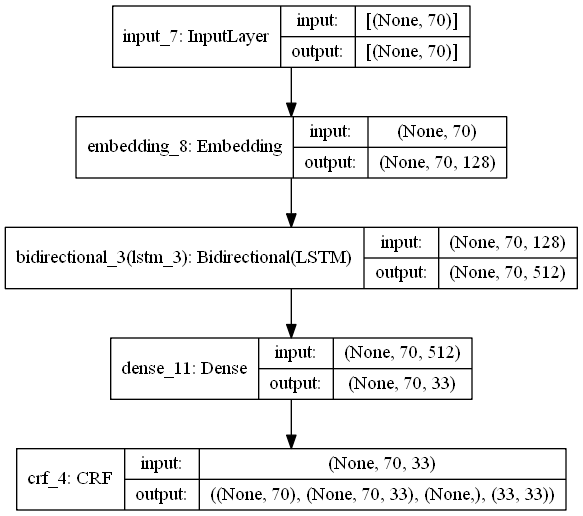

In [57]:
inputs = Input(shape=(70,), dtype='int32')
output = Embedding(vocab_size, 128, input_length=max_len, mask_zero=True)(inputs)
output = Bidirectional(LSTM(256, return_sequences=True))(output)
output = Dense(tag_size, activation=None)(output)
crf = CRF(dtype='float32')
output = crf(output)
base_model = Model(inputs, output)
#model = ModelWithCRFLoss(base_model)
#model.compile(optimizer='adam', metrics=['accuracy'])
plot_model(base_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

C:\Users\Samsung\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\autograph\impl\api.py:390: UserWarning:

CRF Decoding does not work with KerasTensors in TF2.4. The bug has since been fixed in tensorflow/tensorflow##45534



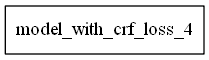

In [106]:
inputs = Input(shape=(70,), dtype='int32')
output = Embedding(vocab_size, 128, input_length=max_len, mask_zero=True)(inputs)
output = Bidirectional(LSTM(256, return_sequences=True))(output)
output = Dense(tag_size, activation=None)(output)
crf = CRF(dtype='float32')
output = crf(output)
base_model = Model(inputs, output)
model = ModelWithCRFLoss(base_model)
model.compile(optimizer='adam', metrics=['accuracy'])
plot_model(model3, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [107]:


history1 = model.fit(X_train, y_train, batch_size=128, epochs=50,  validation_split=0.1)#, callbacks=[F1score(use_char=False)])
loss_,accu_= model.evaluate(X_test,y_test)

accu_

Epoch 1/50
5/5 [==============================] - 12s 1s/step - crf_loss: 74.8503 - accuracy: 0.0036 - val_crf_loss_val: 61.7564 - val_val_accuracy: 0.3560
Epoch 2/50
5/5 [==============================] - 3s 630ms/step - crf_loss: 44.2406 - accuracy: 0.6853 - val_crf_loss_val: 31.5190 - val_val_accuracy: 0.8452
Epoch 3/50
5/5 [==============================] - 3s 654ms/step - crf_loss: 32.3711 - accuracy: 0.8629 - val_crf_loss_val: 22.0080 - val_val_accuracy: 0.8692
Epoch 4/50
5/5 [==============================] - 3s 668ms/step - crf_loss: 21.9972 - accuracy: 0.8698 - val_crf_loss_val: 19.1482 - val_val_accuracy: 0.8692
Epoch 5/50
5/5 [==============================] - 4s 711ms/step - crf_loss: 20.7034 - accuracy: 0.8711 - val_crf_loss_val: 17.5346 - val_val_accuracy: 0.8717
Epoch 6/50
5/5 [==============================] - 4s 792ms/step - crf_loss: 18.4668 - accuracy: 0.8724 - val_crf_loss_val: 16.3431 - val_val_accuracy: 0.8742
Epoch 7/50
5/5 [==============================] - 5s 1

0.9364055395126343

In [221]:
tf.keras.models.save_model(model, r'C:\Users\Samsung\jupyter\Project_Deep_learning_2020\data\NER\model\LSTM-CRF')

INFO:tensorflow:Assets written to: C:\Users\Samsung\jupyter\Project_Deep_learning_2020\data\NER\model\LSTM-CRF\assets


INFO:tensorflow:Assets written to: C:\Users\Samsung\jupyter\Project_Deep_learning_2020\data\NER\model\LSTM-CRF\assets


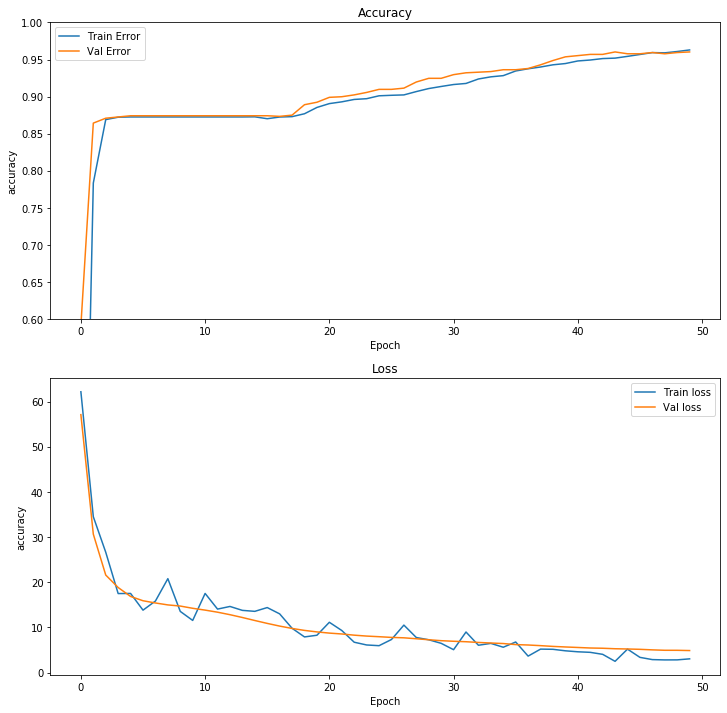

In [166]:
plot_history(history)

In [167]:
hist.tail()

,crf_loss,accuracy,val_crf_loss_val,val_val_accuracy
45,3.373599,0.956836,5.151947,0.957781
46,2.877688,0.959385,5.032083,0.959437
47,2.807037,0.959045,4.940145,0.957781
48,2.818157,0.960829,4.935975,0.959437
49,3.044605,0.962954,4.880503,0.960265


In [223]:
#i=54 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_pred = model.predict(X_test)
for i in [54,20,100,22,25,150,40]:
    print("target: ",i)
    print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
    print(35 * "-")

    for w, t, pred in zip(X_test[i], y_test[i], y_pred[0][i]):
        if w != 0: # PAD값은 제외함.
            print("{:17}: {:7} {}".format(index_to_word[w], index_to_ner[t], index_to_ner[pred]))
    print("==================================")

target:  54
단어             |실제값  |예측값
-----------------------------------
(                : O       O
노이즈              : B-NC    B-NC
켄                : I-NC    O
슬링               : I-NC    I-NC
)                : O       O
생각               : O       O
보다               : O       O
차단               : B-NC    B-NC
이                : O       O
100              : O       O
프로               : O       O
안되다              : O       O
.                : O       O
바깥               : O       O
소리               : O       O
가                : O       O
웅웅               : O       O
울리다              : O       O
들리다              : O       O
.                : O       O
target:  20
단어             |실제값  |예측값
-----------------------------------
안좋다              : O       O
target:  100
단어             |실제값  |예측값
-----------------------------------
뚜껑               : B-CA    B-COM
만                : O       O
열                : O       O
어도               : O       O
연결               : B-PAR   B-COM
잘     

In [136]:
f1score = F1score()

y_predicted = model.predict([X_test])
pred_tags = f1score.sequences_to_tags(y_predicted[1])
y_test = to_categorical(y_test, num_classes=tag_size)
test_tags = f1score.sequences_to_tags(y_test)

In [137]:
len(pred_tags[0]),len(test_tags[0])

(70, 70)

In [138]:
len(np.array(test_tags)),len(np.array(pred_tags))

(156, 156)

In [139]:
print(classification_report(test_tags, pred_tags))

              precision    recall  f1-score   support

          AS       0.00      0.00      0.00         3
         BAT       0.00      0.00      0.00        11
          CA       0.00      0.00      0.00         7
         CAQ       0.15      0.20      0.17        10
         CMP       0.00      0.00      0.00        15
         CNV       1.00      0.14      0.25         7
         COM       0.30      0.52      0.38        27
          DE       0.66      0.53      0.58        40
          FA       0.00      0.00      0.00         3
         FIT       0.82      0.85      0.84        96
          NC       0.62      0.89      0.73        27
         PAR       0.38      0.20      0.26        15
          PR       0.00      0.00      0.00         9
          SQ       0.70      0.59      0.64        51
          TK       0.11      0.14      0.12         7
         WEI       0.00      0.00      0.00         3

   micro avg       0.61      0.54      0.57       331
   macro avg       0.30   

C:\Users\Samsung\anaconda3\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



# CRF

In [163]:
X = pad_sequences(X, padding='post', maxlen=max_len)
y = pad_sequences(y, padding='post', maxlen=max_len)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=777)

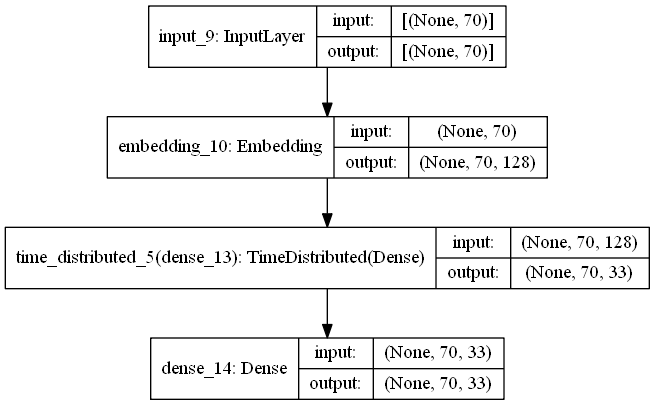

In [113]:

inputs = Input(shape=(70,), dtype='int32')
output = Embedding(vocab_size, 128, input_length=max_len, mask_zero=True)(inputs)
output = TimeDistributed(Dense(tag_size, activation=('softmax')))(output)
output = Dense(tag_size, activation=None)(output)
base_model = Model(inputs, output)
model3 = ModelWithCRFLoss(base_model)
model3.compile(optimizer='adam', metrics=['accuracy'])
plot_model(base_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

C:\Users\Samsung\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\autograph\impl\api.py:390: UserWarning:

CRF Decoding does not work with KerasTensors in TF2.4. The bug has since been fixed in tensorflow/tensorflow##45534



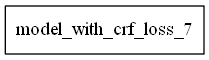

In [166]:
X = pad_sequences(X, padding='post', maxlen=max_len)
y = pad_sequences(y, padding='post', maxlen=max_len)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=777)
inputs = Input(shape=(70,), dtype='int32')
output = Embedding(vocab_size, 128, input_length=max_len, mask_zero=True)(inputs)
output = TimeDistributed(Dense(tag_size, activation=('softmax')))(output)
output = Dense(tag_size, activation=None)(output)
crf = CRF(dtype='float32')
output = crf(output)
base_model = Model(inputs, output)
model3 = ModelWithCRFLoss(base_model)
model3.compile(optimizer='adam', metrics=['accuracy'])
plot_model(model3, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [167]:
history3 = model3.fit(X_train, y_train, batch_size=128, epochs=50,  validation_split=0.1)#, callbacks=[F1score(use_char=False)])


Epoch 1/50
5/5 [==============================] - 3s 225ms/step - crf_loss: 72.4031 - accuracy: 0.0024 - val_crf_loss_val: 68.2266 - val_val_accuracy: 0.0050
Epoch 2/50
5/5 [==============================] - 0s 99ms/step - crf_loss: 76.4939 - accuracy: 0.0028 - val_crf_loss_val: 67.6807 - val_val_accuracy: 0.0075
Epoch 3/50
5/5 [==============================] - 0s 91ms/step - crf_loss: 73.8036 - accuracy: 0.0068 - val_crf_loss_val: 67.1207 - val_val_accuracy: 0.0099
Epoch 4/50
5/5 [==============================] - 0s 96ms/step - crf_loss: 70.0541 - accuracy: 0.0151 - val_crf_loss_val: 66.5443 - val_val_accuracy: 0.0331
Epoch 5/50
5/5 [==============================] - 0s 92ms/step - crf_loss: 76.9052 - accuracy: 0.0591 - val_crf_loss_val: 65.9526 - val_val_accuracy: 0.0985
Epoch 6/50
5/5 [==============================] - 0s 92ms/step - crf_loss: 75.8251 - accuracy: 0.1006 - val_crf_loss_val: 65.3313 - val_val_accuracy: 0.1126
Epoch 7/50
5/5 [==============================] - 0s 91ms

In [225]:
tf.keras.models.save_model(model3, r'C:\Users\Samsung\jupyter\Project_Deep_learning_2020\data\NER\model\CRF')

INFO:tensorflow:Assets written to: C:\Users\Samsung\jupyter\Project_Deep_learning_2020\data\NER\model\CRF\assets


INFO:tensorflow:Assets written to: C:\Users\Samsung\jupyter\Project_Deep_learning_2020\data\NER\model\CRF\assets


In [226]:
loss_,accu_= model3.evaluate(X_test,y_test)

accu_

5/5 [==============================] - 0s 43ms/step - crf_loss_val: 10.7930 - val_accuracy: 0.8987


0.8943164348602295

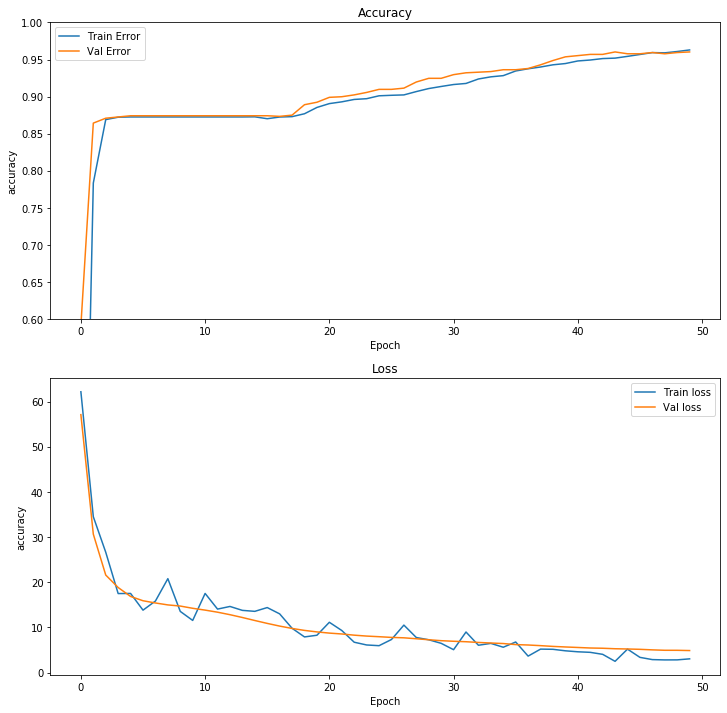

In [230]:
hist3 = plot_history(history)

In [232]:
hist3.tail()

,crf_loss,accuracy,val_crf_loss_val,val_val_accuracy,epoch
45,3.373599,0.956836,5.151947,0.957781,45
46,2.877688,0.959385,5.032083,0.959437,46
47,2.807037,0.959045,4.940145,0.957781,47
48,2.818157,0.960829,4.935975,0.959437,48
49,3.044605,0.962954,4.880503,0.960265,49


In [229]:
y_pred = model3.predict(X_test)
#i=54 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_pred = model.predict(X_test)
for i in [54,20,100,22,25,150,40]:
    print("target: ",i)
    print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
    print(35 * "-")

    for w, t, pred in zip(X_test[i], y_test[i], y_pred[0][i]):
        if w != 0: # PAD값은 제외함.
            print("{:17}: {:7} {}".format(index_to_word[w], index_to_ner[t], index_to_ner[pred]))
    print("==================================")

target:  54
단어             |실제값  |예측값
-----------------------------------
(                : O       O
노이즈              : B-NC    B-NC
켄                : I-NC    O
슬링               : I-NC    I-NC
)                : O       O
생각               : O       O
보다               : O       O
차단               : B-NC    B-NC
이                : O       O
100              : O       O
프로               : O       O
안되다              : O       O
.                : O       O
바깥               : O       O
소리               : O       O
가                : O       O
웅웅               : O       O
울리다              : O       O
들리다              : O       O
.                : O       O
target:  20
단어             |실제값  |예측값
-----------------------------------
안좋다              : O       O
target:  100
단어             |실제값  |예측값
-----------------------------------
뚜껑               : B-CA    B-COM
만                : O       O
열                : O       O
어도               : O       O
연결               : B-PAR   B-COM
잘     

In [173]:
f1score = F1score()

y_predicted = model3.predict([X_test])
pred_tags = f1score.sequences_to_tags(y_predicted[1])
y_test = to_categorical(y_test, num_classes=tag_size)
test_tags = f1score.sequences_to_tags(y_test)

In [175]:
print(classification_report(test_tags, pred_tags))

              precision    recall  f1-score   support

          AS       0.00      0.00      0.00         3
         BAT       0.00      0.00      0.00        11
          CA       0.00      0.00      0.00         7
         CAQ       0.00      0.00      0.00        10
         CMP       0.00      0.00      0.00        15
         CNV       0.00      0.00      0.00         7
         COM       0.00      0.00      0.00        27
          DE       0.00      0.00      0.00        40
          FA       0.00      0.00      0.00         3
         FIT       0.00      0.00      0.00        96
          NC       0.67      0.44      0.53        27
         PAR       0.00      0.00      0.00        15
          PR       0.00      0.00      0.00         9
          SQ       0.00      0.00      0.00        51
          TK       0.00      0.00      0.00         7
         WEI       0.00      0.00      0.00         3

   micro avg       0.32      0.04      0.07       331
   macro avg       0.04   